A brief introduction Copula
===
本文旨在为数理基础一般的同学提供一个使用Copula分析数据的教程，内容上会比专业教材少一些公式、细节和严谨性，多一点作者本人的碎碎念便于初学者理解。Copula理论可以应用在时间序列分析中分析残差的联动性，此外在风险管理中也有有趣的应用(KMV)。为了开发和应用的便利，本文采用的是Python语言中的copulas包，它的接口更加规范且功能更强大，可以适应各种定制需求。亦可用R语言完成，但许多包已经不再维护，且原始代码许多变量命名随意、api调用关系混乱，不推荐。

$Copula$函数可以将多个边缘分布整合成一个联合正态分布，于本教程而言只需二元分布就足够，即：
$$F(x_1,x_2)=C(F_1(x_1), F_2(x_2))  $$
其中，F(x_1,x_2)是规定的联合分布函数,其数值的分布符合在0到1区间上的均匀分布，即U(0,1)。通过函数取逆函数即可获得Copula：
$$C(u1,u2)=F(F^{(-1)}(x_1),F^{(-1)}(x_2))$$
========

### 1. 关于cdf的基本知识

如果对PDF，CDF，逆函数的概念不熟悉，请看这一部分。

F(x)是一个累积概率函数(cdf)，是概率分布函数(pdf)的积分，譬如说对于指数函数，其pdf为
$$f(x) = \begin{cases} 
e^{-x}, & \text{if } x > 0 \\
0, &  \ others \\
\end{cases}$$
pdf为：
$$F(x) = \begin{cases} 
1-e^{-x}, & \text{if } x > 0 \\
0, &  \ others \\
\end{cases}$$
对于其逆函数的求取过程为：
$$F(x)=U$$
$$ F^{(-1)}(U)=x $$
上述两式并不是严谨的写法，意为cdf函数的结果必定是在0到1上的均匀分布的随机变量
$$U=1-e^{-x}$$
$$x=-ln(1-U)$$




即可得出:
$$F^{(-1)}(U)=-ln(1-U)$$

补充几点：
1. 任何一个分布的cdf都应当是U(0,1)分布的，即从0到1，F(x)落在每一个点的概率都相同，想象一下cdf的形状，每一个纵坐标对应且仅对应一个x的取值。第三点会给出更广泛的例子。
2. 在上文中的$x=-ln(1-U)$式，在作为蒙特卡洛模拟手段中常常被改写为$x=-ln(U)$，因为U和1-U服从同样的分布。这样的操作可以用来简化运算，其它类似形式的反函数也是如此。
3. 对于不连续函数的求逆，一般采取“左逆函数”的设定，记为$F^\leftarrow(x)$。举两个例子。

$$F_1(x) = \begin{cases} 
1-e^{-x}, & \text{if } x > 0.5 \\
0.5x, & \text{if } 0.5 \geq x \geq 0 \\
\end{cases}$$

$$F_2(x) = \begin{cases} 
1, & \text{if }  x \geq 0.8 \\
0.8, & \text{if } 0.8 \geq x \geq 0.5 \\
0.5x, & \text{if } 0.8 \geq x  \geq 0 \\
\end{cases}$$

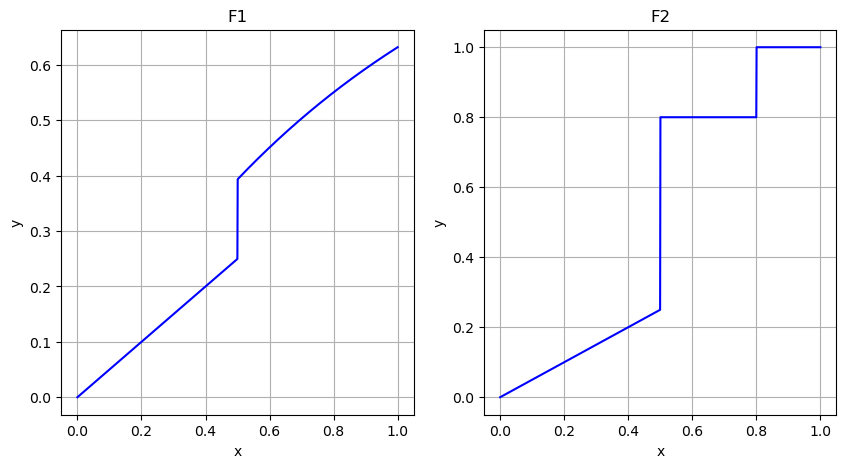

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import copulas
def F1(x):
    if x <= 0.5:
        return 0.5*x
    else:
        return 1-np.exp(-x)
def F2(x):
    if x <= 0.5:
        return 0.5*x
    elif x<=0.8:
        return 0.8
    else:
        return 1
fig,ax=plt.subplots(1,2,figsize=(10,5))
x1 = np.linspace(0, 1, 1000)
y1 = np.array([F1(xi) for xi in x1])
y2 = np.array([F2(xi) for xi in x1])
ax[0].plot(x1, y1, 'b-')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].grid()
ax[0].set_title('F1')
ax[1].plot(x1, y2, 'b-')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].grid()
ax[1].set_title('F2')
plt.show()

对于F1的情况，$F_1^\leftarrow(x)$比较特殊的情况在于$x=0.5$一处，在横轴的此处，“左逆函数”的U取值从$0.25$到$1-e^{-0.5}$，输出都为$x=0.5$。对于F2的情况,特殊点在于，$U=0.8$和$U=1$,当$U=0.8$时，$x$的取值可以在$0.5~0.5$上任意一点，那么$F_1^\leftarrow(0.8)$的答案是多少呢，答案唯一且是0.5(想想为什么要叫做“左逆函数”和使用"$\leftarrow$"的记号)。同理$F_1^\leftarrow(1)=0.8$。

如此扩展后的逆函数的定义，和上文中的第一点可以对应上，“对于逆函数，每个U对应唯一的x”。

对于一组数据，我们很难保证其符合某种标准的分布模式，如正态分布、指数分布、帕累托分布等，所以我们会根据数据来拟合出一个经验累计概率分布（empirical cdf），它是由数据拟合出来的，所以只有在数据量足够大时我们才能建模。

注意：在下面使用的python代码中，scoreatpercentile函数并不是我们此前讨论过的“左逆函数”，当U的分位数没有切确对应的x时，它的答案是插值得到的。（虽然本文中并没有直接用到“左逆函数”，但在VaR和Expected shortfall的计算当中其是必不可少的！）

不难看出，在n=500这样较小的情况下,拟合效果都是不错的。若增大到5000的样本量，效果会更好。

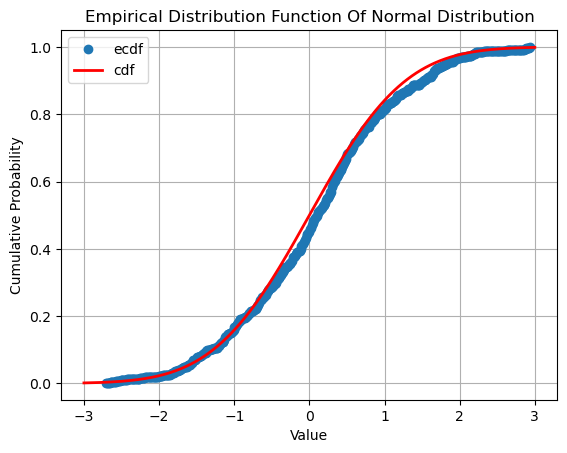

In [104]:
from scipy import stats
# 生成样本数据
n=500
data = np.random.normal(size=n, loc=0)
# 计算经验分布函数
x=np.linspace(-3, 3, n)
edf = stats.cumfreq(data, numbins=n)
cdf = stats.norm.cdf(x, loc=0)
# 获取累积频数
cumulative_freq = edf.cumcount / len(data)
# 获取样本数据的值域
values = edf.lowerlimit + np.linspace(0, edf.binsize * edf.cumcount.size, edf.cumcount.size)

# 绘制经验分布函数图像
#注意两个分布不共用同样的x!因为两个分布的值域不同
plt.plot(values, cumulative_freq,  'o',label='ecdf',)
plt.plot(x, cdf, 'r-',label='cdf',linewidth=2)
plt.legend()
plt.xlabel('Value')
plt.ylabel('Cumulative Probability')
plt.title('Empirical Distribution Function Of Normal Distribution')
plt.grid(True)
plt.show()

# 计算经验分布函数的逆函数（分位数）
quantiles = np.linspace(0, 1, 100)
inverse_edf = stats.scoreatpercentile(data, quantiles)

### 2. 使用Copula工具对数据进行建模

引入数据集进行分析与建模, 此处引用的是年龄和收入的关系。不难看出两者具有明显的相关性，但传统的相关系数得出的相关性并不是很强，主要原因是离群值大大影响到了相关系数的呈现效果。

一些碎碎念：“相关系数”是一个很容易被混淆概念的词语，绝大部分情况下它指的是“皮尔森相关系数”，其特点在于研究变量之间线性关联程度，所以大多数时候“相关”（Correlated）都指代的是线性关系。“相关一定不独立，不独立不一定导致相关”是一个正确的论断，它常出现在面试当中，彻底解决这个模棱两可的问题办法很简单：把“correlate”和“linear”两个词彻底绑定，如线性相关（linear correlated），线性相关性（linear correlation），线性相关系数（linear correlation coefficient）。

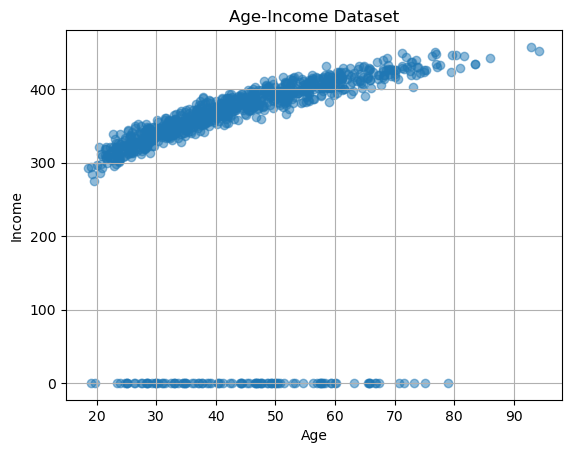

相关系数：
              age    income
age     1.000000  0.224357
income  0.224357  1.000000


In [116]:
from copulas.datasets import sample_bivariate_age_income
# 双样本数据集，包含年龄和收入，具有高相关性和离群值
dataset=sample_bivariate_age_income(size=1000, seed=42)
plt.scatter(dataset['age'], dataset['income'], alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Age-Income Dataset')
plt.grid(True)
plt.show()
print("相关系数：\n",dataset.corr())

In [125]:
from copulas.bivariate import clayton,frank,gumbel
from copulas.multivariate import GaussianMultivariate
from copulas.visualization import scatter_2d, compare_2d


